In [149]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd.variable import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import time
import matplotlib.pyplot as plt

Loading dataset from the file. For now, not normalized but may want to explore normalization.

In [150]:
dataset = pd.read_csv('19000-spotify-songs/cleaned_song_data.csv', index_col=0)

In [151]:
X = dataset.drop(labels = ['song_name', 'avg_song_popularity'], axis=1).values
X = torch.tensor(X).float()

In [152]:
Y = dataset['avg_song_popularity'].values
Y = Y[:, None]
Y = torch.tensor(Y).float()

In [153]:
X.shape, Y.shape

(torch.Size([13070, 13]), torch.Size([13070, 1]))

In [154]:
dataset = torch.utils.data.TensorDataset(X, Y)

In [155]:
validation_split = 0.30
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

train_split, val_split = torch.utils.data.random_split(dataset, [dataset_size - split, split])

# np.random.shuffle(indices)
# train_indices, val_indices = indices[split:], indices[:split]

# # Creating PT data samplers and loaders:
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)

# train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
#                                            sampler=train_sampler)
# validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                                 sampler=valid_sampler)

In [156]:
batch_size = 100
shuffle = True

train_loader = torch.utils.data.DataLoader(train_split, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_split, batch_size = batch_size, shuffle = True)

# train_data_loader = torch.utils.data.DataLoader(dataset, 
#                                                 batch_size = batch_size,
#                                                 sampler = train_sampler)

# valid_data_loader = torch.utils.data.DataLoader(dataset,
#                                                     batch_size = batch_size,
#                                                     sampler = valid_sampler)

Architecture:

1) Input 100 x 13
2) FC with 52 units, ReLU
3) FC with 104 units, ReLU
4) FC with 52 units, ReLU
5) FC with 13 units, ReLU
6) FC with 1 unit, linear

In [157]:
class my_Net(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(my_Net, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(in_dim, in_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_dim*2, in_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_dim*2, in_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_dim, out_dim)
        )
        

    def forward(self, x):
        return self.fc(x)

In [158]:
def train(data_loader, num_epochs = 10):
        
    in_dim = next(iter(data_loader))[0].size()[1]
    out_dim = 1
    
    net = my_Net(in_dim, out_dim)
    
    #Initialize loss function & optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(net.parameters())
    
    train_hist = {}
    train_hist['loss'] = []
    train_hist['per_epoch_time'] = []
    train_hist['total_time'] = []
    
    start_time = time.time()

    for epoch in range(num_epochs):

        epoch_start_time = time.time()

        for i, (x, y) in enumerate(data_loader, 0):
            batch_start_time = time.time()

            b_size = x.size()[0]

            net.zero_grad()

            x = Variable(x)
            y = Variable(y)

            output = net(x)

            loss = loss_fn(output, y)

            loss.backward()
            optimizer.step()


            train_hist['loss'].append(loss.item())

        train_hist['per_epoch_time'].append(time.time() - epoch_start_time)

        train_hist['total_time'].append(time.time() - start_time)
        print("Completed epoch {}".format(epoch+1))
    return train_hist, net

In [160]:
train_hist, net = train(train_loader)
# valid_pred = 

Completed epoch 1
Completed epoch 2
Completed epoch 3
Completed epoch 4
Completed epoch 5
Completed epoch 6
Completed epoch 7
Completed epoch 8
Completed epoch 9
Completed epoch 10


In [165]:
valid_MSE = 0
loss_fn = nn.MSELoss()

with torch.no_grad():
    for i, (x, y) in enumerate(val_loader):
        b_size = x.size()[0]
        x = Variable(x)
        y = Variable(y)

        output = net(x)

        loss = loss_fn(output, y)
        valid_MSE += b_size*loss.item()

valid_MSE /= len(val_indices)
# len(val_indices)
valid_MSE, train_hist['loss'][-1]


(10879.596621283035, 16438.7265625)

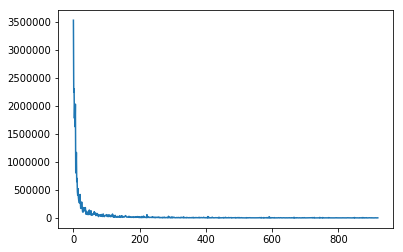

In [124]:
plt.plot(train_hist['loss'])